# Convolutions-Vision-Transformers

Implementation of [CvT: Introducing Convolutions to Vision Transformers](https://arxiv.org/abs/2103.15808)

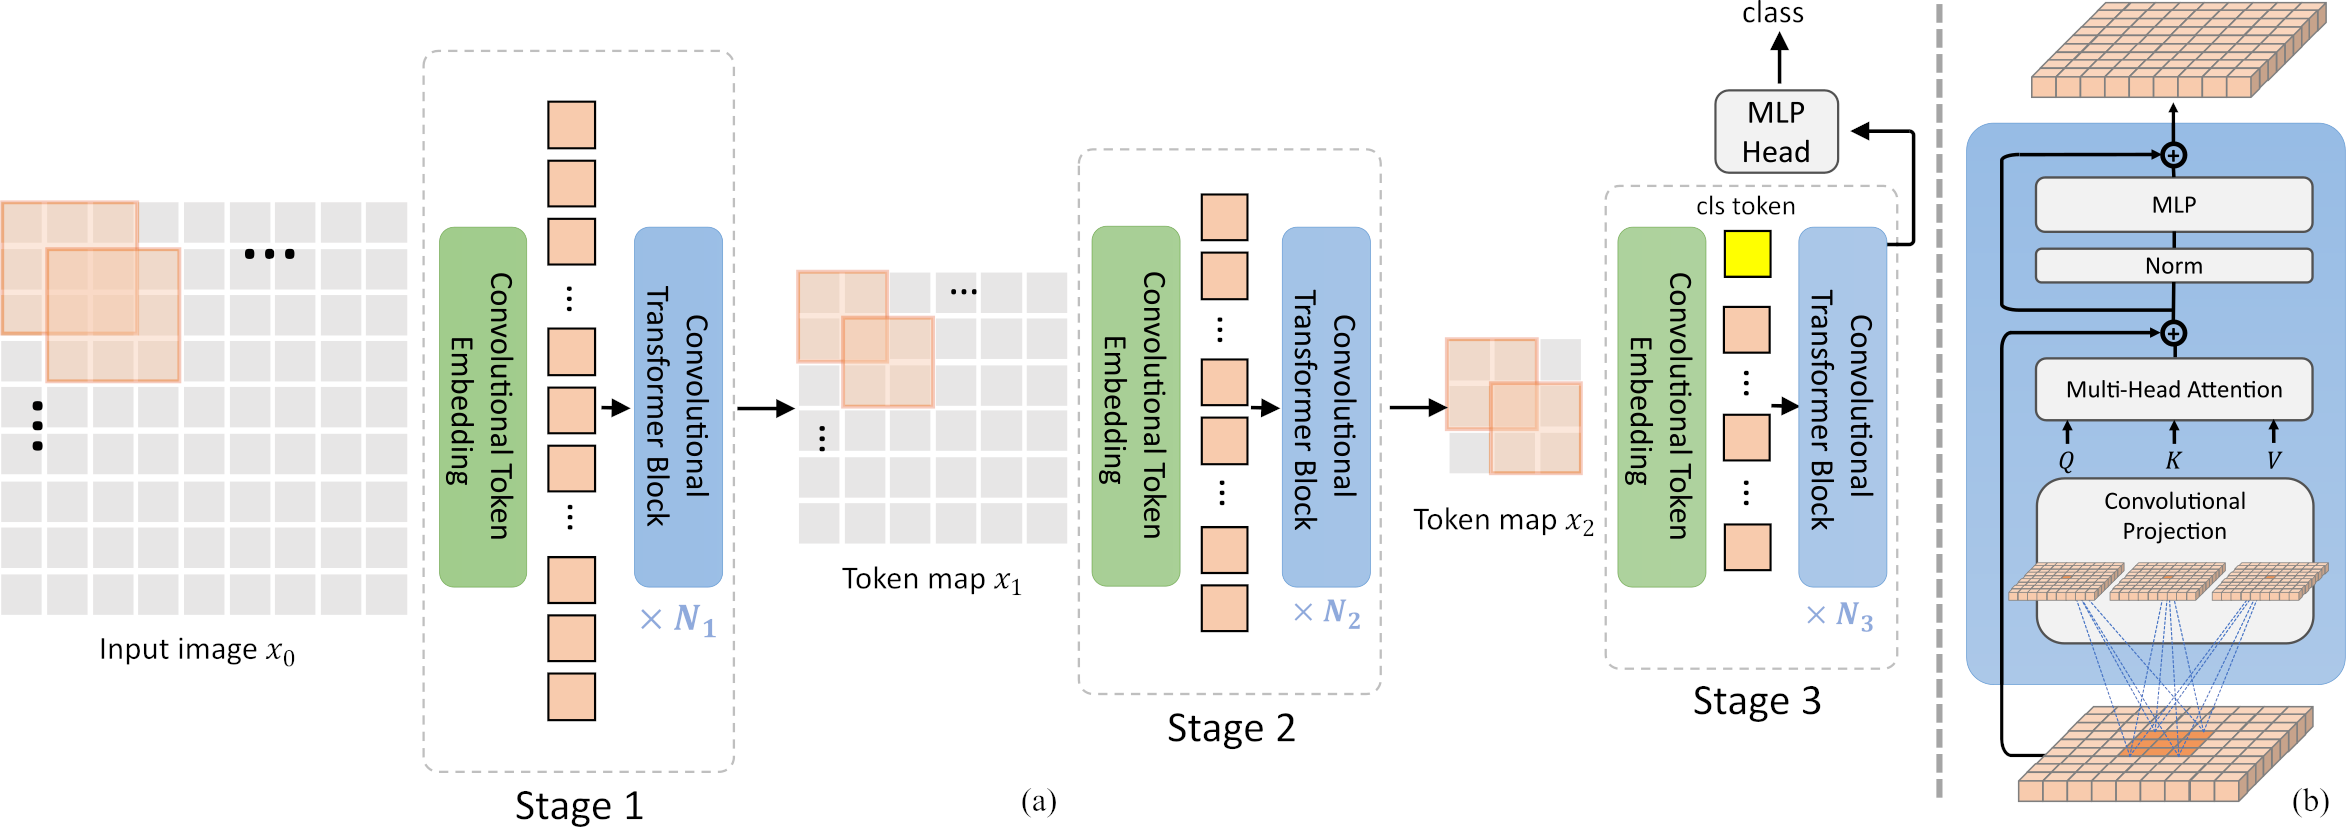

University of Rome, La Sapienza. Artificial Intelligence and Robotics. Neural Networks Course A.Y. 2022/23

Esteban Vincent | Aurélien Lurois

# Dataset Description: Tom & Jerry Image Classification

Dataset used: [Tom and Jerry Image classification | Kaggle](https://www.kaggle.com/datasets/balabaskar/tom-and-jerry-image-classification)

This dataset contains more than 5k images (exactly 5478 images) extracted from some of Tom & Jerry's show videos that are available online. The downloaded videos were converted into images with 1 frame per second (1 FPS) and hand-labeled to detect the presence of characters Tom and Jerry'jerry' in any given image. The images are categorized into 4 classes: no characters present, only Jerry, only Tom, or both. We have preprocessed the dataset to shuffle all images into one folder, resize the images from 1280\*720 and 854\*480 to 128\*128 pixels, and create a csv file that associates each image with its class label.<br>
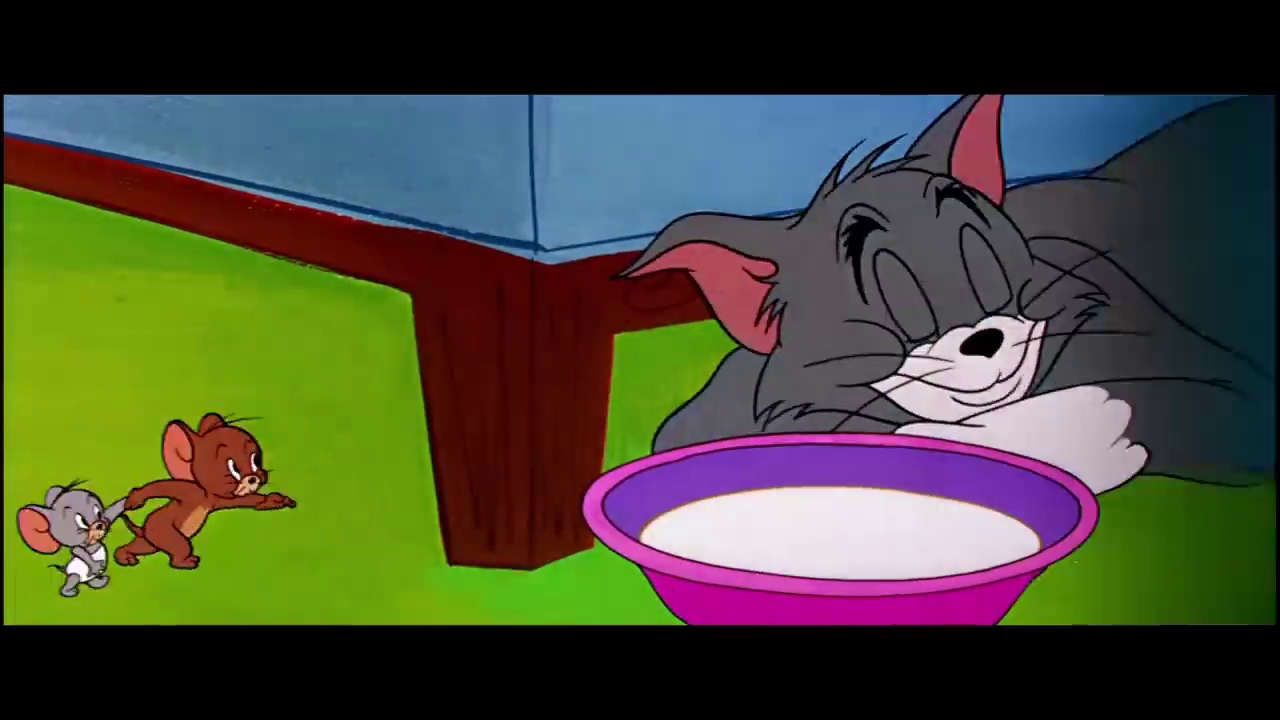 <br>
Original image<br>

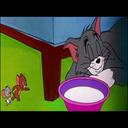 <br>
Preprocessed image

# Setup

In [1]:
#@title Clone the repository
# You do not need to run this cell if you have already cloned the repository
!git clone https://github.com/EstebanVincent/Convolutions-Vision-Transformers.git
%cd Convolutions-Vision-Transformers/
!ls

Cloning into 'Convolutions-Vision-Transformers'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 107 (delta 0), reused 2 (delta 0), pack-reused 104
Receiving objects: 100% (107/107), 158.24 MiB | 27.65 MiB/s, done.
Resolving deltas: 100% (48/48), done.
/content/Convolutions-Vision-Transformers
cvt	     figures  models	 requirements.txt  Submission.ipynb
dataset.zip  main.py  README.md  setup.py


In [2]:
#@title Install dependencies
!pip install -q -r requirements.txt 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 177.3 kB/s eta 0:00:00


In [3]:
#@title Import dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix
import zipfile

In [4]:
#@title Define variables
model_name = 'CvT'
n_epochs = 50
batch_size = 64
output_dir = 'models' 
lr = 1e-4
size = 128

In [5]:
#@title Unzip the preprocessed dataset
with zipfile.ZipFile("dataset.zip","r") as zip_ref:
    zip_ref.extractall()

In [ ]:
#@title Preprocessing the dataset
# Run only if you wish to preprocess the dataset again 
# (to change the size of the images for example).
# Note that you need to have the kaggle API key configured 
# and that this will download a 456 MB archive.
!python main.py --setup --size $size

# Training

In [6]:
#@title Train the model
!python main.py --train                         \
                --model_name $model_name        \
                --n_epochs $n_epochs            \
                --batch_size $batch_size        \
                --output_dir $output_dir        \
                --lr $lr                        \
                --size $size

Epoch 1 training loss: 1.342 accuracy: 0.368
Epoch 2 training loss: 1.321 accuracy: 0.403
Epoch 3 training loss: 1.302 accuracy: 0.422
Epoch 4 training loss: 1.298 accuracy: 0.432
Epoch 5 training loss: 1.264 accuracy: 0.450
Epoch 6 training loss: 1.215 accuracy: 0.520
Epoch 7 training loss: 1.203 accuracy: 0.536
Epoch 8 training loss: 1.145 accuracy: 0.591
Epoch 9 training loss: 1.123 accuracy: 0.618
Epoch 10 training loss: 1.128 accuracy: 0.613
Epoch 11 training loss: 1.098 accuracy: 0.642
Epoch 12 training loss: 1.067 accuracy: 0.672
Epoch 13 training loss: 1.048 accuracy: 0.689
Epoch 14 training loss: 1.037 accuracy: 0.701
Epoch 15 training loss: 1.023 accuracy: 0.718
Epoch 16 training loss: 1.024 accuracy: 0.717
Epoch 17 training loss: 1.010 accuracy: 0.730
Epoch 18 training loss: 1.011 accuracy: 0.732
Epoch 19 training loss: 1.019 accuracy: 0.721
Epoch 20 training loss: 1.008 accuracy: 0.733
Epoch 21 training loss: 0.992 accuracy: 0.749
Epoch 22 training loss: 0.984 accuracy: 0.7

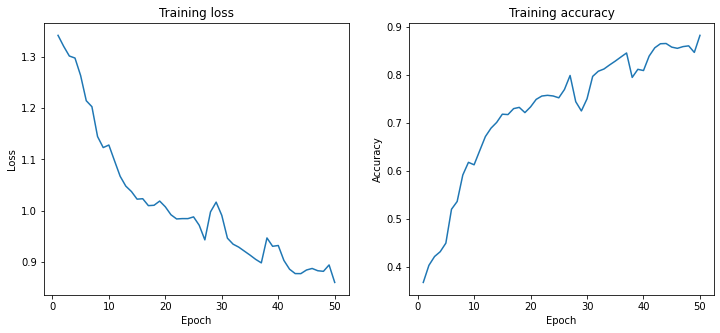

In [7]:
#@title Tracing the evolution of loss and accuracy over time
df = pd.read_csv(f'{output_dir}/{model_name}_loss_acc.csv')
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Tracing the evolution of loss over time
ax[0].plot(df['epoch'], df['loss'])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training loss')

# Tracing the evolution of accuracy over time
ax[1].plot(df['epoch'], df['accuracy'])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training accuracy')

plt.show()

# Evaluation

In [8]:
#@title Evaluate the model
!python main.py --evaluate                      \
                --model_name $model_name        \
                --size $size                    \
                --batch_size $batch_size        \
                --output_dir $output_dir

Images: 100% 18/18 [00:03<00:00,  5.04it/s]
Accuracy: 0.7728102189781022


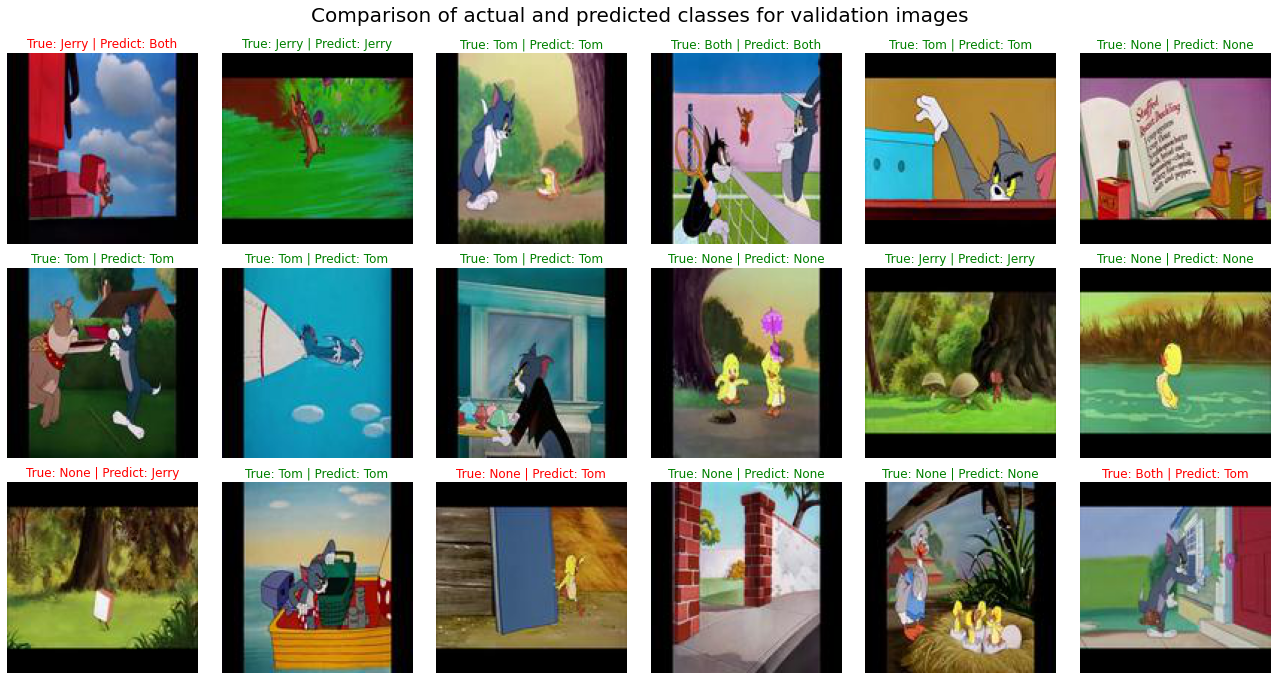

In [9]:
#@title Display results
label_name = ['None', 'Jerry', 'Tom', 'Both']

df = pd.read_csv(f'{output_dir}/{model_name}_prediction.csv')
df_sample = df.sample(n=18, random_state=42).reset_index(drop=True)

fig = plt.figure(figsize=(18, 10))

for i, row in df_sample.iterrows():
    if i >= 18: break
    image = Image.open('dataset/imgs/' + row['filename'])
    ax = fig.add_subplot(3, 6, i + 1)
    ax.imshow(image)
    ax.set_title(f"True: {label_name[row['class']]} | Predict: {label_name[row['prediction']]}",
                 color=("green" if row['class'] == row['prediction'] else "red"))
    ax.axis("off")

fig.suptitle("Comparison of actual and predicted classes for validation images", fontsize=20)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

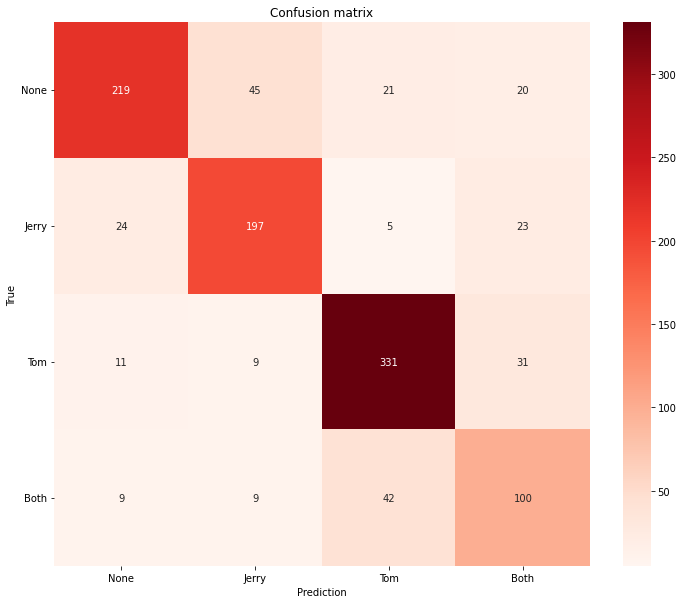

In [10]:
#@title Confusion matrix
cm = confusion_matrix(df['class'], df['prediction'])
fig = plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, cmap="Reds", fmt='d')
plt.xlabel("Prediction")
plt.ylabel("True")
plt.title("Confusion matrix")
plt.xticks(np.arange(len(label_name))+.5, label_name)
plt.yticks(np.arange(len(label_name))+.5, label_name, rotation=0)
plt.show()

The confusion matrix shows that the model is doing very well in detecting the presence of Tom. However, it has a bit of a harder time recognizing Jerry, which can be explained by his smaller size, making him easily confused with a background element.